<h1><strong><u>Logistic Regression Model</u></strong><h1>

In [1]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>Logistic Regression Model Selection</u></strong><h2>

<h3><strong><u>Validation Curve Test</u></strong></h3>

In [ ]:
for title, metric in clf_metrics.items():
    pipeline = Pipeline(
        [
            ("clf", LogisticRegression(random_state=1))
        ]
    ) 

    alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
    train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring=metric,
                                                    param_name="clf__C",
                                                    param_range=alphas,
                                                    n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    vc_dict[f"Logistic Regession: {title} VC"] = [alphas, 
                                                       [train_scores_mean, validation_scores_mean], 
                                                       ["Regularization Coefficient", title],]

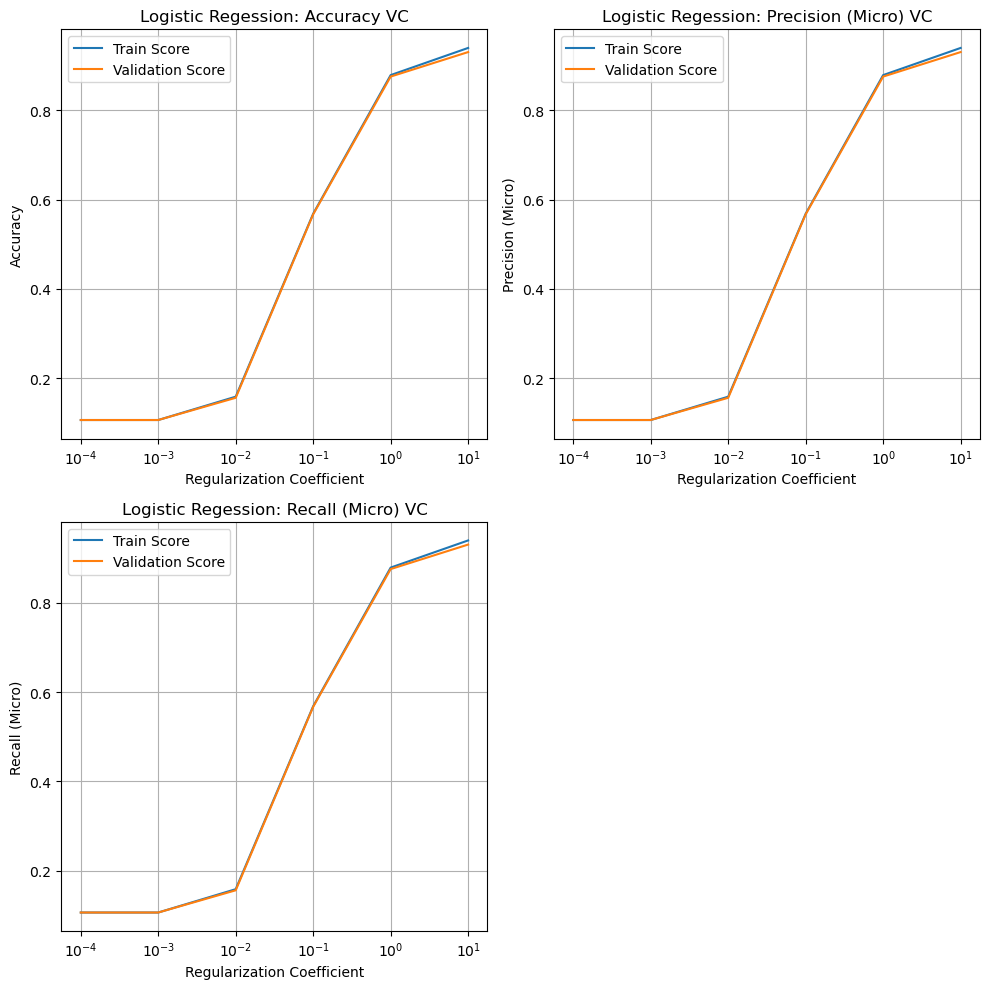

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in vc_dict.items():
    axs[count].semilogx(value[0], value[1][0], label="Train Score")
    axs[count].semilogx(value[0], value[1][1],  label="Validation Score")
    axs[count].set_xlabel(value[2][0])
    axs[count].set_ylabel(value[2][1])
    axs[count].set_title(key)
    axs[count].grid()
    axs[count].minorticks_off()
    axs[count].legend()
    count += 1

# Delete the unused subplot (e.g., the last one for a 3x2 grid with 5 plots)
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Cross-Validation Test</u></strong></h3>

In [ ]:
pipeline = Pipeline(
    [
        ("ct", ct),
        ("clf", LogisticRegression(random_state=1))
    ]
) 
param_grid = {"clf__C": [1, 4, 7, 10]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
log_model = grid_search.best_estimator_

def log_penguin_classifier():
    return log_model

Best Parameters:  {'clf__C': 4}


<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The VC test clearly reports that low regularization is necessary for best results.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curve Tests</u></strong></h3>

In [20]:
for key, value in clf_metrics.items():
    logistic_train_sizes, logistic_train_scores, logistic_validation_scores = learning_curve(
        log_model,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    logistic_train_scores_mean = np.mean(logistic_train_scores, axis=1)
    logistic_train_scores_std = np.std(logistic_train_scores, axis=1)
    logistic_validation_scores_mean = np.mean(logistic_validation_scores, axis=1)
    logistic_validation_scores_std = np.std(logistic_validation_scores, axis=1)

    # Calculate spread of data around the mean
    logistic_train_range_minus = logistic_train_scores_mean - logistic_train_scores_std
    logistic_train_range_plus = logistic_train_scores_mean + logistic_train_scores_std
    logistic_validation_range_minus = logistic_validation_scores_mean - logistic_validation_scores_std
    logistic_validation_range_plus = logistic_validation_scores_mean + logistic_validation_scores_std

    lc_dict[key] = [[logistic_train_scores_mean, logistic_validation_scores_mean],
                    [logistic_train_range_minus, logistic_train_range_plus], 
                    [logistic_validation_range_minus, logistic_validation_range_plus], 
                    logistic_train_sizes]

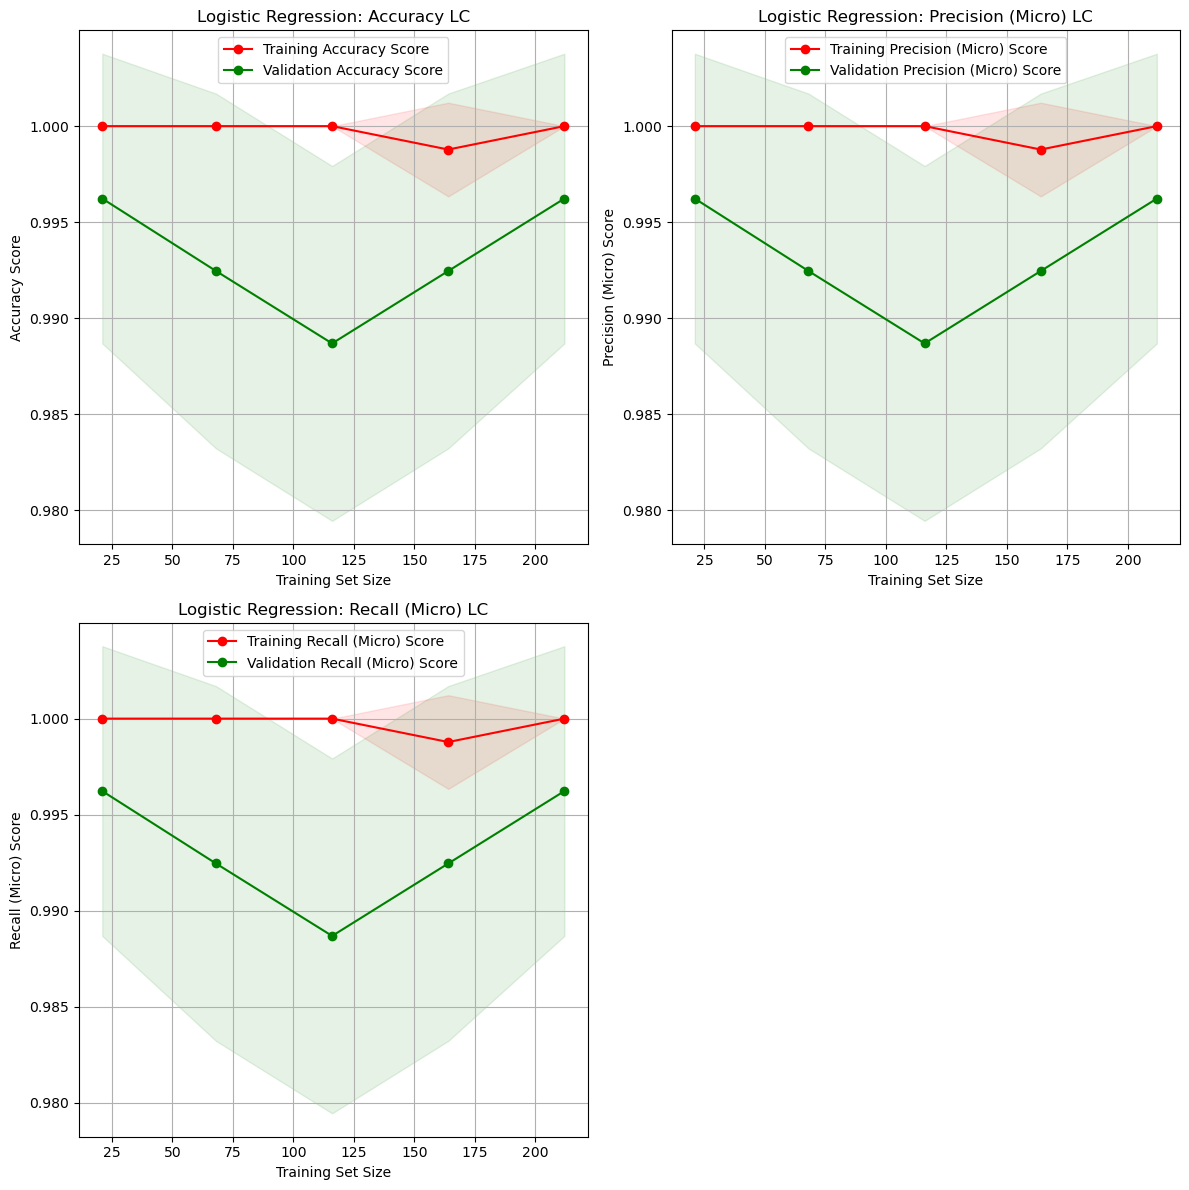

In [21]:
# Plot the learning curves
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"Logistic Regression: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend(loc="best")
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [22]:
for key, value in clf_metrics.items():
    print(f"{key}")
    log_training_values = cross_val_score(log_model, X_train, y_train, scoring=value, cv=5)
    print("CV Training Scores: ", log_training_values)
    np_log_training_values = np.array(log_training_values)
    average = np.mean(np_log_training_values)
    stDev = np.std(np_log_training_values)
    print("Average and Standard Error: {:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [1.         0.98113208 1.         1.         1.        ]
Average and Standard Error: 1.00% ± 0.75% 

Precision (Micro)
CV Training Scores:  [1.         0.98113208 1.         1.         1.        ]
Average and Standard Error: 1.00% ± 0.75% 

Recall (Micro)
CV Training Scores:  [1.         0.98113208 1.         1.         1.        ]
Average and Standard Error: 1.00% ± 0.75% 



Text(0.5, 1.0, 'Logistic Regression: Confusion Matrix (Evaluation)')

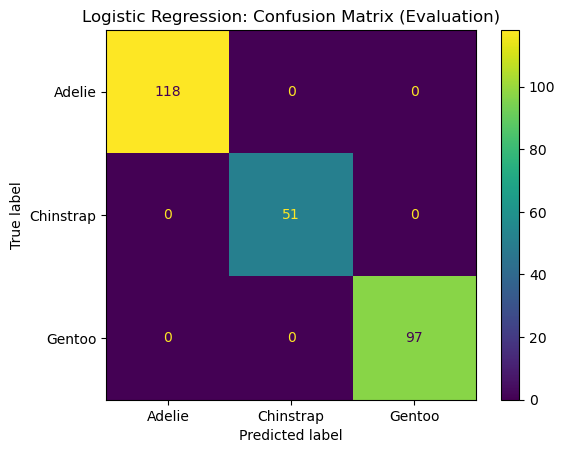

In [24]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(log_model, X_train, y_train)
disp.ax_.set_title("Logistic Regression: Confusion Matrix (Evaluation)")

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected Logistic Regression model, I found positive results for most of the evaluation methods. The learning curve is something to note.